# LeNet-5

Perhaps the first widely known and successful application of convolutional neural networks was **LeNet-5**, described by Yann LeCun, et al. in their 1998 paper titled [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791). The system was developed for use in a handwritten character recognition problem and demonstrated on the **MNIST standard dataset**, achieving approximately 99.2% classification accuracy (or a 0.8% error rate). The network was then described as the central technique in a broader system referred to as **Graph Transformer Networks**.

It is a long paper, and perhaps the best part to focus on is Section II. B. that describes the LeNet-5 architecture. In that section, the paper describes the **network as having seven layers** with input **grayscale images** having the shape **32 x 32**, the size of images in the **MNIST dataset**. 

> The model proposes a pattern of a convolutional layer followed by an average pooling layer, referred to as a **subsampling layer**. 

This pattern is repeated two and a half times before the output feature maps are flattened and fed to some fully connected layers for interpretation and a final prediction. A picture of the network architecture is provided in the paper and reproduced below.

<img width="800" src="https://drive.google.com/uc?export=view&id=1nqbLzHfqorX80I8upHMWINwPNfrmLW-V"/>

The pattern of blocks of convolutional layers and pooling layers (referred to as **subsampling**) grouped and repeated **remains a typical pattern in designing and using convolutional neural networks today, more than twenty years later**. Interestingly, the architecture uses a small number of filters with a modest size as the first hidden layer, specifically 6 filters, each with 5x5 pixels. After pooling, another convolutional layer has many more filters, again with the same size, precisely 16 filters with 5x5 pixels, again followed by pooling. In the repetition of these two blocks of convolution and pooling layers, the trend increases the number of filters.

Compared to modern applications, the number of filters is also small, but **the trend of increasing the number of filters with the depth of the network also remains a common pattern in modern usage of the technique.** The flattening of the feature maps and interpretation and classification of the extracted features by fully connected layers also remains a common pattern today. 

> In modern terminology, the **final section of the architecture** is often referred to as the **classifier**, whereas the **convolutional and pooling layers** earlier in the model are referred to as the **feature extractor**.

We can summarize the key aspects of the architecture relevant in modern models as follows:

- Fixed-sized input images.
- Group convolutional and pooling layers into blocks.
- Repetition of convolutional-pooling blocks in the architecture.
- Increase in the number of filters with the depth of the network.
- Distinct feature extraction and classifier parts of the architecture.

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 14.8 MB/s 
     |████████████████████████████████| 182 kB 63.9 MB/s 
     |████████████████████████████████| 166 kB 61.6 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 162 kB 58.8 MB/s 
     |████████████████████████████████| 162 kB 65.9 MB/s 
     |████████████████████████████████| 158 kB 9.3 MB/s 
     |████████████████████████████████| 157 kB 72.9 MB/s 
     |████████████████████████████████| 157 kB 73.2 MB/s 
     |████████████████████████████████| 157 kB 71.3 MB/s 
     |████████████████████████████████| 157 kB 68.4 MB/s 
     |████████████████████████████████| 157 kB 69.5 MB/s 
     |████████████████████████████████| 157 kB 70.8 MB/s 
     |████████████████████████████████| 157 kB 73.4 MB/s 
     |████████████████████████████████| 156 kB 67.8 MB/s 


In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 10.8 MB/s 
     |████████████████████████████████| 66 kB 2.6 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 99 kB 5.5 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=c862f51be61e360bb02eff4dff8f606f36fc8393b5d29840d8711c903a19e924
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


### Import Packages

In [3]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2899591014522014299
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9542855795191893793
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [5]:
# seed for reproducible results
tf.random.set_seed(42)

In [6]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02: Implementing LeNet-5


<img width="800" src="https://drive.google.com/uc?export=view&id=1RF_HWPSImajab-i1ayFeEOoFON0Ky-28"/>

Source code based on **Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019** [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [8]:
class LeNet:
  ''' 
  # create LeNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  '''
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation='tanh', input_shape=(28,28,1), )) #C1
    model.add(AveragePooling2D()) #S2

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='tanh')) #C3
    model.add(AveragePooling2D()) #S4

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    model.add(Dense(84, activation='tanh')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [9]:
# create a model object
model = LeNet.build(28,28,1,10)

# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

## Step 03: Data Augmentation

According to [Goodfellow et al.](https://www.deeplearningbook.org/), regularization is

> “(...) any modification we make to a learning algorithm that is intended to reduce its generalization error, but not its training error”

In short, regularization seeks to reduce our testing error perhaps at the expense of increasing training error slightly.

We’ve already looked at different forms of regularization in the first part of this course; however, these were parameterized forms of regularization, requiring us to update our loss/update
function. In fact, there exist other types of regularization that either:

1. Modify the network architecture itself.
2. Augment the data passed into the network for training.

**Dropout** is a great example of modifying a network architecture by achieving greater generalizability. Here we insert a layer that randomly disconnects nodes from the previous layer to the next layer, thereby ensuring that no single node is responsible for learning how to represent a given class.

In this section we’ll be discussing another type of regularization called **data augmentation**. This method purposely perturbs training examples, changing their appearance slightly, before passing them into the network for training. The end result is that a network consistently sees “new” training data points generated from the original training data, partially alleviating the need for us to gather more training data (though in general, gathering more training data will rarely hurt your algorithm).

**Data augmentation** encompasses a wide range of techniques used to generate new training samples from the original ones by applying random jitters and perturbations such that the classes labels are
not changed. 

> Our goal when applying **data augmentation** is to increase the generalizability of the model. 

Given that our network is constantly seeing new, slightly modified versions of the input data points, it’s able to learn more robust features. 

> At testing time, we do not apply data augmentation
and evaluate our trained network – in most cases, you’ll see an increase in testing accuracy, perhaps at the expense at a slight dip in training accuracy.

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1PWNBYi_ziF8YnCCd25vnmsf9nxq-KsGH"></center><center><b>Left</b>: A sample of 250 data points that follow a normal distribution exactly. <b>Right</b>: Adding a small amount of random “jitter” to the distribution. This type of data augmentation can
increase the generalizability of our networks.</center>


Let’s consider the Figure above (**left**) of a normal distribution with zero mean and unit variance. Training a machine learning model on this data may result in us modeling the distribution exactly –
however, in real-world applications, data rarely follows such a neat distribution.

Instead, to increase the generalizability of our classifier, we may first randomly jitter points along the distribution by adding some values e drawn from a random distribution (**right**). Our plot
still follows an **approximately normal distribution**, but it’s not a perfect distribution as on the left. A model trained on this data is more likely to generalize to example data points not included in the
training set.
  **In the context of computer vision, data augmentation lends itself naturally**. For example, we can obtain additional training data from the original images by apply simple geometric transforms such as random:

1. Translations
2. Rotations
3. Changes in scale
4. Shearing
5. Horizontal (and in some cases, vertical) flips

Applying a (small) amount of these transformations to an input image will change its appearance slightly, but it does not change the class label – thereby making data augmentation a very natural, easy method to apply to deep learning for computer vision tasks.

### Fetch, Preprocessing and Data Segregation

In [10]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5"
}

In [11]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",
                 project=args["project_name"], 
                 job_type="Train")

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


In [12]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

21-10-2022 10:48:05 [INFO] accessing MNIST...


11490434/11490434 [==============================] - 0s 0us/step


21-10-2022 10:48:05 Train x: (60000, 28, 28, 1)
21-10-2022 10:48:05 Train y: (60000,)
21-10-2022 10:48:05 Test x: (10000, 28, 28, 1)
21-10-2022 10:48:05 Test y: (10000,)


In [13]:
# visualize 18 numbers
def show_image(train_image, label, index):
    plt.subplot(3, 6, index+1)
    plt.imshow(tf.squeeze(train_image), cmap=plt.cm.gray)
    plt.title(label)
    plt.grid(b=False)

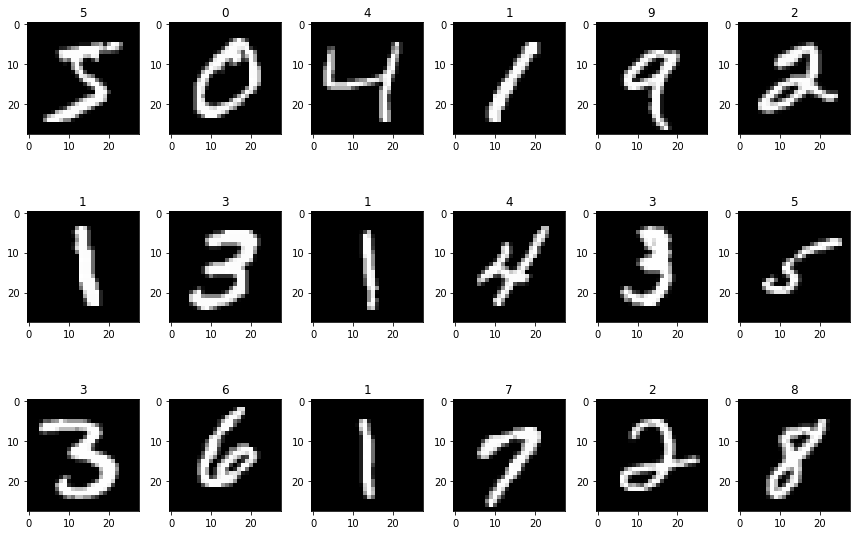

In [14]:
# visualize the first 18 numbers
plt.figure(figsize=(12, 8))
for index in range(18):
    label = train_y[index]
    image_pixels = train_x[index,:,:,:]
    show_image(image_pixels, label, index)
plt.tight_layout()

[INFO] generating images...


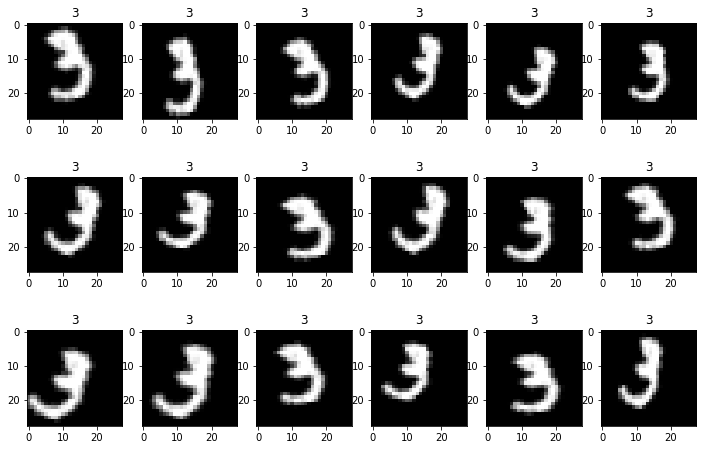

In [15]:
# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=False, fill_mode="nearest")
total = 0
image = train_x[10:11,:,:,:]

# construct the actual Python generator
print("[INFO] generating images...")
imageGen = aug.flow(image, batch_size=1)

# create a figure
plt.figure(figsize=(12, 8))

# loop over examples from our image data augmentation generator
for img in imageGen:

  show_image(img, train_y[10], total)

  # increment our counter
  total += 1

  # if we have reached 10 examples, break from the loop
  if total == 18:
    break

In [16]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training

In [17]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=False, fill_mode="nearest")

# train the network
logger.info("[INFO] training network...")
history = model.fit(aug.flow(train_x, train_y, batch_size=32),
                    validation_data=(test_x, test_y), epochs=20, verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                         compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

21-10-2022 10:48:11 [INFO] compiling model...
21-10-2022 10:48:11 [INFO] training network...
21-10-2022 10:48:11 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Evaluation Metrics

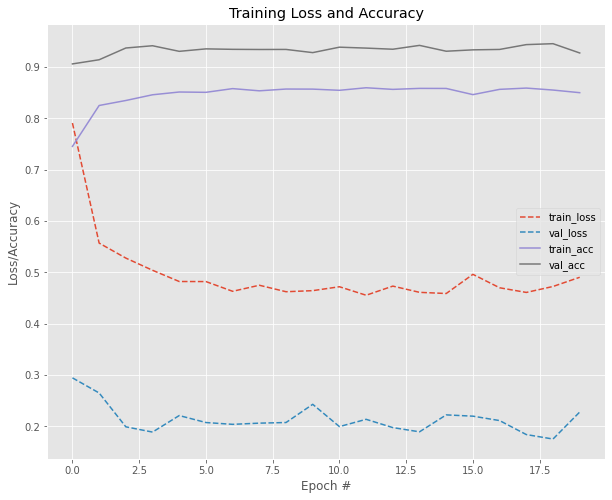

In [18]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [19]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.009409145899650773 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0006014034225321365 kWh
[INFO] Energy consumed for all GPU: 0.003428811894350251 kWh
[INFO] Energy consumed for all CPU: 0.005378930582768388 kWh
[INFO] CO2 emission 0.00425877491053784(in Kg)


In [20]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       980
           1       0.99      0.96      0.97      1135
           2       0.86      0.96      0.91      1032
           3       0.92      0.94      0.93      1010
           4       0.94      0.95      0.94       982
           5       0.96      0.92      0.94       892
           6       0.95      0.96      0.96       958
           7       0.87      0.86      0.86      1028
           8       0.90      0.89      0.90       974
           9       0.92      0.88      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



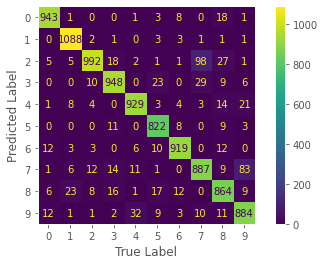

In [21]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [22]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

21-10-2022 10:55:49 Uploading figures


In [23]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

21-10-2022 10:55:49 Validation Evaluation metrics
21-10-2022 10:55:49 Validation Accuracy: 0.9276
21-10-2022 10:55:49 Validation Precision: 0.9286042592247937
21-10-2022 10:55:49 Validation Recall: 0.9276
21-10-2022 10:55:49 Validation F1: 0.9276974102189802


In [24]:
run.finish()

accuracy,▁▆▆▇▇▇█████████▇███▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂
val_accuracy,▁▂▇▇▅▆▆▆▆▅▇▆▆▇▅▆▆██▅
val_loss,█▆▂▂▄▃▃▃▃▅▂▃▂▂▄▄▃▂▁▄
Acc,0.9276
CO2_Emissions,0.00426
Count_Params,61706
Energy_CPU,0.00538
Energy_Consumed,0.00941
Energy_GPU,0.00343


# Extensions

This section lists some ideas for extending that you may wish to explore.

- **Batch normalization**. Implement BN technique after the CONV Layer review the final result.
- **Dropout**. Analyze the use of regularization based on dropout technique and placed with different intensity after the Pooling layer.
- **Other activation functions**. Investigate change the activation function to relu and compare the results.


# Step 04: Hyperparameter Tuning

In [25]:
# Configure the sweep 
sweep_config = {
    "name": "my-lenet-sweep",
    'method': 'random', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'conv_layer': {
            'max': 2,
            'min': 1,
            'distribution': 'int_uniform',
        },
        'batch_norm': {
            'values': [True, False]
        },
        'learn_rate': {
            'values': [0.001,0.005],  
        },
        'epoch': {
            'values': [15, 30]
        },
        'batch_size': {
            'values': [32,64]
        },
        'activation': {
            'values' : ['relu']
        },
        'dropout':{
            'values' : [0.0, 0.25, 0.5]
        },
        'rotation': {
            'values' : [0, 30, 35]
        },
        'width_shift': {
            'values' : [0.1, 0.2, 0.3]
        },
        'height_shift': {
            'values' : [0.1, 0.2, 0.3]
        },
        'shear' : {
            'values' : [0.1, 0.2, 0.3]   
        },
        'zoom' : {
            'values' : [0.1, 0.2, 0.3]   
        }
    }
}

In [26]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config,
                       entity="morsinaldo",
                       project=args["project_name"])

Create sweep with ID: qfcxxivp
Sweep URL: https://wandb.ai/morsinaldo/lenet-5/sweeps/qfcxxivp


In [27]:
class LeNetDataAugumentation:
  @staticmethod
  def build(width, height, depth, classes, config):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    for i in range(config.conv_layer):
        # define a convolution layer followed by a relu activation 
        # CONV => RELU layer
        model.add(Conv2D(6, (5,5), padding="same", strides=1,
                         input_shape=inputShape)) #C1
        model.add(Activation(config.activation))
    
    model.add(MaxPooling2D()) #S2

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid')) #C3
    if config.batch_norm:
      model.add(BatchNormalization())
    model.add(Activation(config.activation))
    model.add(MaxPooling2D()) #S4

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation=config.activation)) #C5
    model.add(Dropout(config.dropout))
    model.add(Dense(84, activation=config.activation)) #F6
    model.add(Dropout(config.dropout))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [28]:
def train():
  with wandb.init() as run:
    # create codecarbon tracker
    # codecarbon is too much verbose, change the log level for more info
    tracker = EmissionsTracker(log_level="critical")
    tracker.start()

    # initialize the optimizer and model
    logger.info("[INFO] compiling model...")
    opt = Adam(learning_rate=run.config.learn_rate)
    model = LeNetDataAugumentation.build(width=28, height=28, depth=1, 
                                         classes=10, config=run.config)
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

    # construct the image generator for data augmentation then
    # initialize the total number of images generated thus far
    aug = ImageDataGenerator(rotation_range=run.config.rotation,
                             width_shift_range=run.config.width_shift,
                            height_shift_range=run.config.height_shift, 
                             shear_range=run.config.shear, 
                            zoom_range=run.config.zoom,
                            horizontal_flip=False, fill_mode="nearest")

    # train the network
    logger.info("[INFO] training network...")
    history = model.fit(aug.flow(train_x, train_y, batch_size=32),
                        validation_data=(test_x, test_y),
                        epochs=run.config.epoch, 
                        verbose=0,
                        callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                            compute_flops=True)])

    # get co2 emissions from tracker
    # "CO2 emission (in Kg)"
    emissions = tracker.stop()

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(test_x, batch_size=32)
    print(classification_report(test_y.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names=[str(i) for i in lb.classes_]))

    # Evaluation Metrics
    logger.info("Validation Evaluation metrics")
    fbeta = fbeta_score(test_y.argmax(axis=1), 
                        predictions.argmax(axis=1), 
                        beta=1, zero_division=1,average='weighted')
    precision = precision_score(test_y.argmax(axis=1),
                                predictions.argmax(axis=1),
                                zero_division=1,average='weighted')
    recall = recall_score(test_y.argmax(axis=1),
                          predictions.argmax(axis=1),
                          zero_division=1,average='weighted')
    acc = accuracy_score(test_y.argmax(axis=1),
                        predictions.argmax(axis=1))

    logger.info("Validation Accuracy: {}".format(acc))
    logger.info("Validation Precision: {}".format(precision))
    logger.info("Validation Recall: {}".format(recall))
    logger.info("Validation F1: {}".format(fbeta))

    run.summary["Acc"] = acc
    run.summary["Precision"] = precision
    run.summary["Recall"] = recall
    run.summary["F1"] = fbeta
    # number of parameters
    run.summary["Count_Params"] = model.count_params()
    # energy unit is kWh
    run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
    run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
    run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
    run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
    # kg
    run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

    run.finish()

In [29]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id = sweep_id, function=train, count=10)

wandb: Agent Starting Run: s5j7jlue with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 30
wandb: 	height_shift: 0.3
wandb: 	learn_rate: 0.001
wandb: 	rotation: 35
wandb: 	shear: 0.3
wandb: 	width_shift: 0.1
wandb: 	zoom: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 10:57:50 [INFO] compiling model...
21-10-2022 10:57:50 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:08:40 Validation Evaluation metrics


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.96      1.00      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



21-10-2022 11:08:40 Validation Accuracy: 0.9825
21-10-2022 11:08:40 Validation Precision: 0.9826271793242344
21-10-2022 11:08:40 Validation Recall: 0.9825
21-10-2022 11:08:40 Validation F1: 0.9825076909866042


accuracy,▁▅▆▇▇▇▇▇██████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇████▇██▇▇█▇█
val_loss,█▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▂▂▂▁▁▁
Acc,0.9825
CO2_Emissions,0.00607
Count_Params,61770
Energy_CPU,0.00766
Energy_Consumed,0.01341
Energy_GPU,0.00489


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qznrk35g with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	conv_layer: 2
wandb: 	dropout: 0.5
wandb: 	epoch: 15
wandb: 	height_shift: 0.2
wandb: 	learn_rate: 0.001
wandb: 	rotation: 30
wandb: 	shear: 0.1
wandb: 	width_shift: 0.1
wandb: 	zoom: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 11:08:59 [INFO] compiling model...
21-10-2022 11:08:59 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:14:36 Validation Evaluation metrics


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



21-10-2022 11:14:36 Validation Accuracy: 0.9868
21-10-2022 11:14:36 Validation Precision: 0.9868619095781034
21-10-2022 11:14:36 Validation Recall: 0.9868
21-10-2022 11:14:36 Validation F1: 0.9867989269343712


accuracy,▁▆▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▆▇▇▇▇▇██▆▇
val_loss,█▆▃▂▂▃▂▂▂▁▂▁▁▄▂
Acc,0.9868
CO2_Emissions,0.00319
Count_Params,62612
Energy_CPU,0.00397
Energy_Consumed,0.00705
Energy_GPU,0.00264


wandb: Agent Starting Run: z8089w2t with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	dropout: 0.25
wandb: 	epoch: 15
wandb: 	height_shift: 0.2
wandb: 	learn_rate: 0.005
wandb: 	rotation: 30
wandb: 	shear: 0.2
wandb: 	width_shift: 0.3
wandb: 	zoom: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 11:14:51 [INFO] compiling model...
21-10-2022 11:14:51 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:20:24 Validation Evaluation metrics
21-10-2022 11:20:24 Validation Accuracy: 0.9658
21-10-2022 11:20:24 Validation Precision: 0.9660838772394713
21-10-2022 11:20:24 Validation Recall: 0.9658
21-10-2022 11:20:24 Validation F1: 0.9657623106561235


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.98      0.97      1010
           4       0.96      0.95      0.96       982
           5       0.96      0.98      0.97       892
           6       0.98      0.93      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



accuracy,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇▆▇▇▇█▇▆█▇█▇█
val_loss,█▂▂▃▁▁▁▁▁▃▁▁▁▂▁
Acc,0.9658
CO2_Emissions,0.00316
Count_Params,62612
Energy_CPU,0.00392
Energy_Consumed,0.00698
Energy_GPU,0.00262


wandb: Agent Starting Run: 3z3uud5o with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 30
wandb: 	height_shift: 0.2
wandb: 	learn_rate: 0.001
wandb: 	rotation: 30
wandb: 	shear: 0.1
wandb: 	width_shift: 0.3
wandb: 	zoom: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 11:20:38 [INFO] compiling model...
21-10-2022 11:20:38 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:31:21 Validation Evaluation metrics
21-10-2022 11:31:21 Validation Accuracy: 0.9804
21-10-2022 11:31:21 Validation Precision: 0.9805801539769847
21-10-2022 11:31:21 Validation Recall: 0.9804
21-10-2022 11:31:21 Validation F1: 0.9803950462066845


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.96      1.00      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.96      0.98       892
           6       0.99      0.98      0.99       958
           7       0.96      0.98      0.97      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



accuracy,▁▆▆▇▇▇▇▇██████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▆▆▆▇▇▇▇▇█▇▇▇▇▇███▇▇████▇██
val_loss,█▄▂▃▃▃▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▂▂▂▁▁▁▂▁▁
Acc,0.9804
CO2_Emissions,0.00608
Count_Params,61706
Energy_CPU,0.00759
Energy_Consumed,0.01342
Energy_GPU,0.00499


wandb: Agent Starting Run: 2dkykiqt with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	conv_layer: 2
wandb: 	dropout: 0.5
wandb: 	epoch: 15
wandb: 	height_shift: 0.1
wandb: 	learn_rate: 0.005
wandb: 	rotation: 30
wandb: 	shear: 0.3
wandb: 	width_shift: 0.3
wandb: 	zoom: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 11:31:37 [INFO] compiling model...
21-10-2022 11:31:37 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:37:10 Validation Evaluation metrics
21-10-2022 11:37:10 Validation Accuracy: 0.9652
21-10-2022 11:37:10 Validation Precision: 0.9660507660517437
21-10-2022 11:37:10 Validation Recall: 0.9652
21-10-2022 11:37:10 Validation F1: 0.9653313252687802


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       980
           1       1.00      0.97      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.97      0.97       982
           5       0.95      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.91      0.98      0.94      1028
           8       0.98      0.94      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



accuracy,▁▅▆▆▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▆▆▆▇▇█████████
val_loss,█▃▃▃▂▂▁▁▁▁▁▁▁▁▁
Acc,0.9652
CO2_Emissions,0.00316
Count_Params,62676
Energy_CPU,0.00393
Energy_Consumed,0.00698
Energy_GPU,0.00261


wandb: Agent Starting Run: jn4i8qas with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	dropout: 0.25
wandb: 	epoch: 15
wandb: 	height_shift: 0.1
wandb: 	learn_rate: 0.001
wandb: 	rotation: 0
wandb: 	shear: 0.2
wandb: 	width_shift: 0.2
wandb: 	zoom: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 11:37:25 [INFO] compiling model...
21-10-2022 11:37:25 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:42:34 Validation Evaluation metrics


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.97      1.00      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



21-10-2022 11:42:34 Validation Accuracy: 0.9866
21-10-2022 11:42:34 Validation Precision: 0.9867483522175496
21-10-2022 11:42:34 Validation Recall: 0.9866
21-10-2022 11:42:34 Validation F1: 0.986594019701575


accuracy,▁▆▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆▆▇▇▇▆▇▇███▇
val_loss,█▅▃▃▃▂▂▂▃▂▂▁▁▁▂
Acc,0.9866
CO2_Emissions,0.00292
Count_Params,61770
Energy_CPU,0.00364
Energy_Consumed,0.00644
Energy_GPU,0.0024


wandb: Agent Starting Run: vaxsxe36 with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	conv_layer: 1
wandb: 	dropout: 0.5
wandb: 	epoch: 30
wandb: 	height_shift: 0.3
wandb: 	learn_rate: 0.001
wandb: 	rotation: 0
wandb: 	shear: 0.3
wandb: 	width_shift: 0.3
wandb: 	zoom: 0.1


21-10-2022 11:42:52 [INFO] compiling model...
21-10-2022 11:42:52 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:53:04 Validation Evaluation metrics


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



21-10-2022 11:53:04 Validation Accuracy: 0.9827
21-10-2022 11:53:04 Validation Precision: 0.9828244907230074
21-10-2022 11:53:05 Validation Recall: 0.9827
21-10-2022 11:53:05 Validation F1: 0.9826986342549342


accuracy,▁▆▇▇▇▇▇▇██████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆▆▆▇▇▇▇█▇▇██▇▇██▇██████████
val_loss,█▅▃▃▂▃▂▂▂▁▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁
Acc,0.9827
CO2_Emissions,0.00578
Count_Params,61706
Energy_CPU,0.00723
Energy_Consumed,0.01277
Energy_GPU,0.00474


wandb: Agent Starting Run: f8cggox8 with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	conv_layer: 1
wandb: 	dropout: 0.25
wandb: 	epoch: 15
wandb: 	height_shift: 0.1
wandb: 	learn_rate: 0.005
wandb: 	rotation: 35
wandb: 	shear: 0.2
wandb: 	width_shift: 0.1
wandb: 	zoom: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 11:53:20 [INFO] compiling model...
21-10-2022 11:53:20 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 11:58:40 Validation Evaluation metrics


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



21-10-2022 11:58:40 Validation Accuracy: 0.9832
21-10-2022 11:58:40 Validation Precision: 0.983272014503864
21-10-2022 11:58:40 Validation Recall: 0.9832
21-10-2022 11:58:40 Validation F1: 0.9832006189742702


accuracy,▁▆▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▂▄▅▂▆▆▇▆▂█▁▅▅█
val_loss,▄▅▄▃▅▂▂▂▁▅▁█▄▄▁
Acc,0.9832
CO2_Emissions,0.003
Count_Params,61706
Energy_CPU,0.00378
Energy_Consumed,0.00662
Energy_GPU,0.00242


wandb: Agent Starting Run: pz2p5om2 with config:
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	conv_layer: 2
wandb: 	dropout: 0
wandb: 	epoch: 30
wandb: 	height_shift: 0.1
wandb: 	learn_rate: 0.001
wandb: 	rotation: 0
wandb: 	shear: 0.3
wandb: 	width_shift: 0.1
wandb: 	zoom: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 11:58:56 [INFO] compiling model...
21-10-2022 11:58:56 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 12:09:38 Validation Evaluation metrics
21-10-2022 12:09:38 Validation Accuracy: 0.9931
21-10-2022 12:09:38 Validation Precision: 0.9931176756286033
21-10-2022 12:09:38 Validation Recall: 0.9931
21-10-2022 12:09:38 Validation F1: 0.9931024931343025


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      1.00      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      1.00      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



accuracy,▁▆▇▇▇▇▇▇██████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇▅▃▆▆█▇▆█▆▆▆▇▇█▇▇▇█▇██▇
val_loss,█▆▄▄▂▃▂▂▃▅▃▃▁▂▃▁▂▃▃▁▂▁▂▁▁▁▂▁▁▂
Acc,0.9931
CO2_Emissions,0.00602
Count_Params,62612
Energy_CPU,0.00756
Energy_Consumed,0.01329
Energy_GPU,0.00489


wandb: Agent Starting Run: exzd90g6 with config:
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	conv_layer: 2
wandb: 	dropout: 0.5
wandb: 	epoch: 15
wandb: 	height_shift: 0.2
wandb: 	learn_rate: 0.001
wandb: 	rotation: 30
wandb: 	shear: 0.1
wandb: 	width_shift: 0.3
wandb: 	zoom: 0.3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


21-10-2022 12:09:54 [INFO] compiling model...
21-10-2022 12:09:54 [INFO] training network...


[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step


21-10-2022 12:15:28 Validation Evaluation metrics
21-10-2022 12:15:28 Validation Accuracy: 0.9785
21-10-2022 12:15:28 Validation Precision: 0.9786279067649686
21-10-2022 12:15:28 Validation Recall: 0.9785
21-10-2022 12:15:28 Validation F1: 0.978517027828682


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.96      0.99      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.99      0.97      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



accuracy,▁▅▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▆▆▇▇▇▆▇█▇█
val_loss,█▄▃▂▂▃▂▂▂▂▃▂▁▁▁
Acc,0.9785
CO2_Emissions,0.00312
Count_Params,62676
Energy_CPU,0.00394
Energy_Consumed,0.0069
Energy_GPU,0.00252


In [30]:
run.finish()

# Step 05: Train and Export the Best Model

### Fetch, Processing and Data Segregation

**Important**: Disconnect and delete runtime to not link next experiment with sweep.

`Runtime >> Disconnect and Delete Runtime`

Run `Step 01: Setup` and `Step 05: Train and Export the Best Model`

In [8]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5",
  "encoder": "target_encoder",
  "inference_model": "best_model"
}

In [9]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",
                 project=args["project_name"], 
                 job_type="Best_model")

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


In [10]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

21-10-2022 13:23:33 [INFO] accessing MNIST...


11490434/11490434 [==============================] - 0s 0us/step


21-10-2022 13:23:34 Train x: (60000, 28, 28, 1)
21-10-2022 13:23:34 Train y: (60000,)
21-10-2022 13:23:34 Test x: (10000, 28, 28, 1)
21-10-2022 13:23:34 Test y: (10000,)


In [15]:
# visualize 18 numbers
def show_image(train_image, label, index):
    plt.subplot(3, 6, index+1)
    plt.imshow(tf.squeeze(train_image), cmap=plt.cm.gray)
    plt.title(label)
    plt.grid(b=False)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


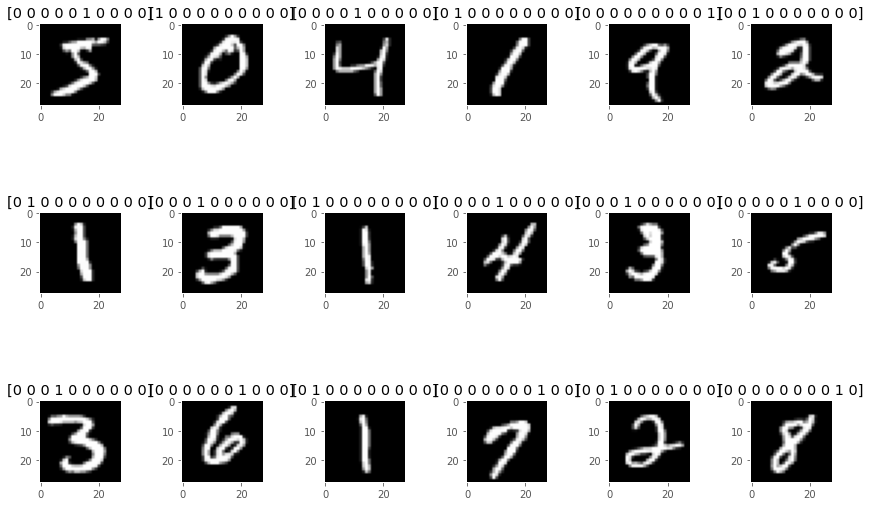

In [16]:
# visualize the first 18 numbers
plt.figure(figsize=(12, 8))
for index in range(18):
    label = train_y[index]
    image_pixels = train_x[index,:,:,:]
    show_image(image_pixels, label, index)
plt.tight_layout()

[INFO] generating images...


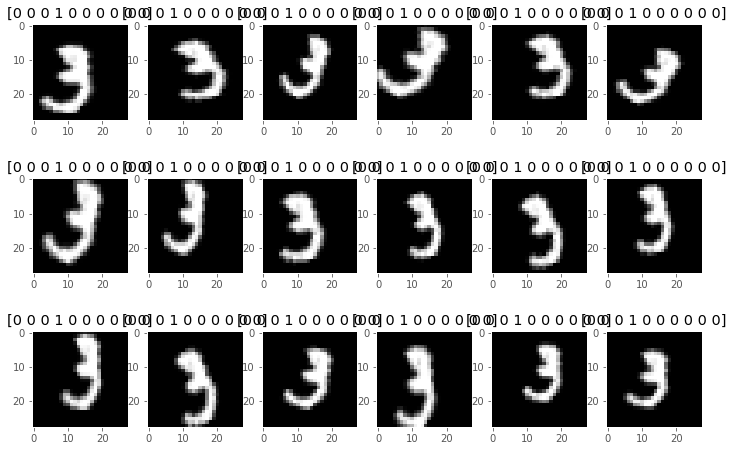

In [17]:
# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=False, fill_mode="nearest")
total = 0
image = train_x[10:11,:,:,:]

# construct the actual Python generator
print("[INFO] generating images...")
imageGen = aug.flow(image, batch_size=1)

# create a figure
plt.figure(figsize=(12, 8))

# loop over examples from our image data augmentation generator
for img in imageGen:

  show_image(img, train_y[10], total)

  # increment our counter
  total += 1

  # if we have reached 10 examples, break from the loop
  if total == 18:
    break

In [11]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training

In [12]:
class BestLeNetDataAugumentation:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    for i in range(1):
        # define a convolution layer followed by a relu activation 
        # CONV => RELU layer
        model.add(Conv2D(6, (5,5), padding="same", strides=1,
                         input_shape=inputShape)) #C1
        model.add(Activation('relu'))
    
    model.add(MaxPooling2D()) #S2

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid')) #C3
    
    model.add(Activation('relu'))
    model.add(MaxPooling2D()) #S4

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='relu')) #C5
    model.add(Dense(84, activation='relu')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [13]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.001)
model = BestLeNetDataAugumentation.build(width=28, height=28, depth=1,classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=0,
                          width_shift_range=0.1,
                        height_shift_range=0.1, 
                          shear_range=0.3, 
                        zoom_range=0.2,
                        horizontal_flip=False, fill_mode="nearest")

# train the network
logger.info("[INFO] training network...")
history = model.fit(aug.flow(train_x, train_y, batch_size=32),
                    validation_data=(test_x, test_y),
                    epochs=30, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                        compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

21-10-2022 13:23:46 [INFO] compiling model...
21-10-2022 13:23:46 [INFO] training network...
21-10-2022 13:23:46 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Evaluation Metrics

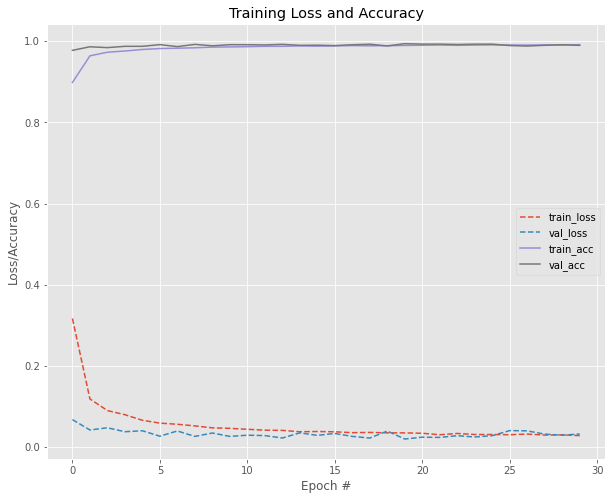

In [19]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 30), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 30), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 30), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 30), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [20]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.0158540276988573 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.000973637064112402 kWh
[INFO] Energy consumed for all GPU: 0.006171264425856735 kWh
[INFO] Energy consumed for all CPU: 0.00870912620888816 kWh
[INFO] CO2 emission 0.005041580808236622(in Kg)


In [21]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.96      1.00      0.98      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



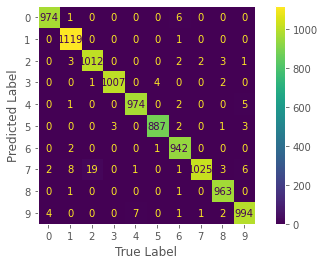

In [22]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [23]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

21-10-2022 13:40:46 Uploading figures


In [24]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

21-10-2022 13:40:46 Validation Evaluation metrics
21-10-2022 13:40:46 Validation Accuracy: 0.9897
21-10-2022 13:40:46 Validation Precision: 0.9898294509179401
21-10-2022 13:40:46 Validation Recall: 0.9897
21-10-2022 13:40:46 Validation F1: 0.9897189440506198


In [25]:
logger.info("Dumping the model and encoder artifacts to the disk")

# Save the artifacts using joblib
joblib.dump(lb, args["encoder"])
joblib.dump(model, args["inference_model"])

21-10-2022 13:40:50 Dumping the model and encoder artifacts to the disk
21-10-2022 13:40:51 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
21-10-2022 13:40:51 Assets written to: ram://01b94945-4e6e-423f-ad5c-2a6adf715373/assets


['best_model']

In [26]:
# encoder artifact
artifact = wandb.Artifact(args["encoder"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the target encoder"
                          )

logger.info("Logging the target encoder artifact")
artifact.add_file(args["encoder"])
run.log_artifact(artifact)

21-10-2022 13:40:51 Logging the target encoder artifact


In [27]:
# inference model artifact
artifact = wandb.Artifact(args["inference_model"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the inference model"
                          )

logger.info("Logging the inference model artifact")
artifact.add_file(args["inference_model"])
run.log_artifact(artifact)

21-10-2022 13:40:52 Logging the inference model artifact


In [28]:
run.finish()

accuracy,▁▆▇▇▇▇▇▇██████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▄▅▅▇▅▇▆▇▇▇▇▆▆▆▇▇▆███▇▇▇▆▆▆▇▆
val_loss,█▄▅▄▄▂▄▂▃▂▂▂▁▃▂▃▂▁▄▁▂▂▂▂▂▄▄▃▂▃
Acc,0.9897
CO2_Emissions,0.00504
Count_Params,61706
Energy_CPU,0.00871
Energy_Consumed,0.01585
Energy_GPU,0.00617
